In [ ]:
import cv2
import numpy as np
import dlib
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/shape_predictor_5_face_landmarks.dat')

In [ ]:
img = '/content/2_r.jpg'
img = cv2.imread(img)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 0)
if len(rects) > 0:
    for rect in rects:
        x = rect.left()
        y = rect.top()
        w = rect.right()
        h = rect.bottom()
        shape = predictor(gray, rect)

In [ ]:
def shape_to_normal(shape):
    shape_normal = []
    for i in range(0, 5):
        shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
    return shape_normal
def get_eyes_nose_dlib(shape):
    nose = shape[4][1]
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

In [ ]:
shape = shape_to_normal(shape)
nose, left_eye, right_eye = get_eyes_nose_dlib(shape)

In [ ]:
center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

In [ ]:
center_pred = (int((x + w) / 2), int((y + y) / 2))

In [ ]:
def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

In [ ]:
length_line1 = distance(center_of_forehead, nose)
length_line2 = distance(center_pred, nose)
length_line3 = distance(center_pred, center_of_forehead)

In [ ]:
def cosine_formula(length_line1, length_line2, length_line3):
    cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
    return cos_a

In [ ]:
cos_a = cosine_formula(length_line1, length_line2, length_line3)
angle = np.arccos(cos_a)

In [ ]:
def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy


def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False

In [ ]:
rotated_point = rotate_point(nose, center_of_forehead, angle)
rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
if is_between(nose, center_of_forehead, center_pred, rotated_point):
    angle = np.degrees(-angle)
else:
    angle = np.degrees(angle)

In [ ]:
img2 = Image.fromarray(img)
img2 = np.array(img2.rotate(angle))

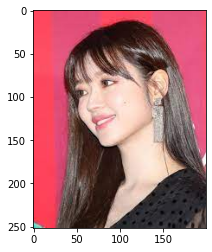

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

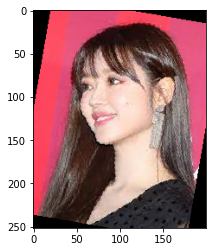

In [ ]:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

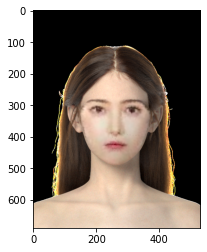

In [ ]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

img = '/content/2.png'
img = cv2.imread(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = cv2.imread("/content/drive/MyDrive/model_face.png")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)




# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))



    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)



# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area



# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

#cv2.imshow("seamlessclone", seamlessclone)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
seamlessclone = cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB)
plt.imshow(seamlessclone)

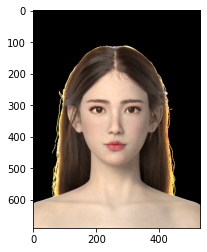

In [ ]:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

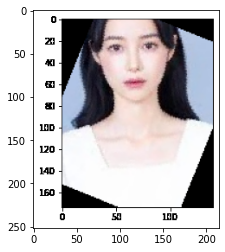

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

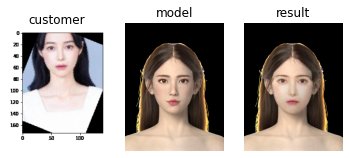

In [ ]:
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis("off")
plt.title('customer')

plt.subplot(1,3,2)
plt.imshow(img2)
plt.axis("off")
plt.title('model')

plt.subplot(1,3,3)
plt.imshow(seamlessclone)
plt.axis("off")
plt.title('result')

plt.show()